C:\Users\raymo\AppData\Local\Temp\ipykernel_14472\3733716926.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.history[-1] = int(self.current_value)  # Ensure it's an integer
C:\Users\raymo\AppData\Local\Temp\ipykernel_14472\3733716926.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = -float((self.current_value - self.target_value) ** 2)  # Ensure the reward is a float
C:\Users\raymo\AppData\Local\Temp\ipykernel_14472\3733716926.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

Total time taken by training: 33.21314883232117 seconds
Total time taken by predicting: 10.800349235534668 seconds
Total time taken by simulation: 30.80490279197693 seconds


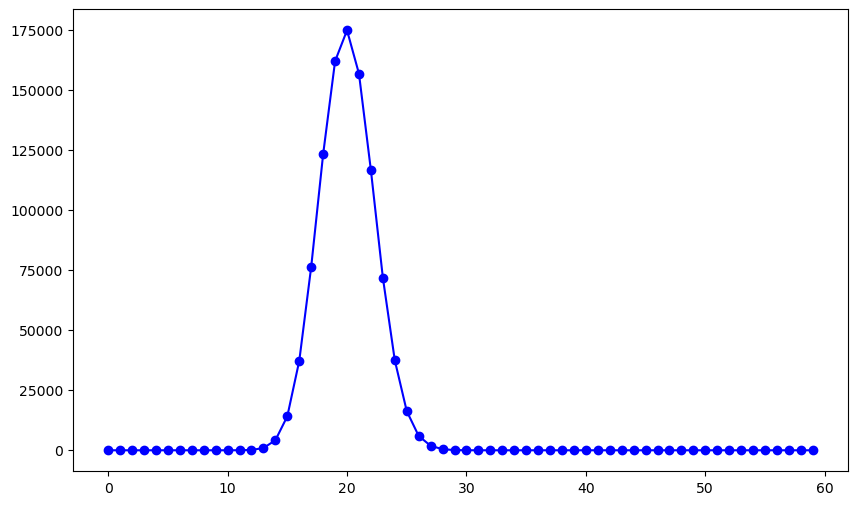

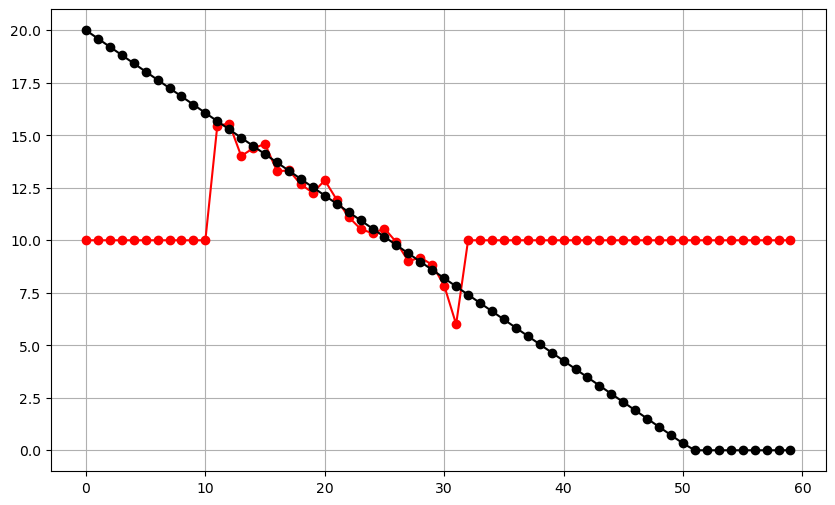

-4.984


In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

from gymnasium import spaces

import molcontrol

class OneMoleculeEnv(gym.Env):
    def __init__(self, initial_value=10, molecule_lifetime = 1, dt = 0.1, max_steps=100, history_length=5, target_value=10, obs_cap=100, render_mode=None):
        super(OneMoleculeEnv, self).__init__()

        self.initial_value = initial_value
        self.prob_death = np.exp(-dt/molecule_lifetime)
        self.dt = dt
        self.max_steps = max_steps
        self.history_length = history_length
        self.target_value = target_value
        self.obs_cap = obs_cap  # Cap for the observation space
        self.render_mode = render_mode

        self.current_value = initial_value
        self.current_step = 0
        self.decays = 0
        self.ideal_action = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(obs_cap)  # the number of molecules to send in ranges from 0 to the cap
        self.observation_space = spaces.Box(
            low=0, high=obs_cap, shape=(history_length,), dtype=np.float32
        )

        # Initialize the history of values
        self.history = np.full(history_length, initial_value, dtype=np.float32)

        # Pre-generate random numbers to avoid generating them at each step
        self.random_numbers = np.random.rand(max_steps)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            self.random_numbers = np.random.rand(self.max_steps)  # Re-generate random numbers if seeded
        self.current_value = self.initial_value
        self.current_step = 0
        self.history = np.full(self.history_length, self.initial_value, dtype=np.int32)
        return self.history, {}

    def _ensure_random_numbers(self):
        # Reset the random numbers if current_step exceeds max_steps
        if self.current_step >= self.max_steps:
            self.random_numbers = np.random.rand(self.max_steps)
            self.current_step = 0  # Reset current step to start fresh

    # First, ensure enough random numbers are available
    # The probability a molecule has decayed in the time interval given is dependent on dt and the lifetime.
    # Decrease the value with a number drawn from a binomial distribution
    # This reflects each molecule having a finite probability of decaying in the timestep
    # The probability a molecule has decayed in the time interval given is dependent on dt and the lifetime.
    # Then add molecules.
    # We then update the history, increase the steps, and calculate the error (reward)
    # Then return the standard gymnasium properties.
    def step(self, action):
        # Ensure enough random numbers are available
        self._ensure_random_numbers()

        self.decays = -np.random.binomial((int)(self.current_value), self.prob_death, 1).item()
        self.current_value += self.decays
        self.ideal_action = self.target_value - self.current_value
        self.current_value += action
        #print ("The options for self current value are ")
        #print (self.current_value, ' ', self.obs_cap)
        #print (self.obs_cap, ' vs ', self.current_value)

        self.current_value = min(self.current_value, self.obs_cap)

        self.history[:-1] = self.history[1:]
        self.history[-1] = int(self.current_value)  # Ensure it's an integer

        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        reward = -float((self.current_value - self.target_value) ** 2)  # Ensure the reward is a float

        return self.history, reward, done, done, self.ideal_action

    def render(self):
        if self.render_mode == 'human':
            print(f"Step: {self.current_step}, Value: {self.current_value}, History: {self.history}")

    def close(self):
        pass

# Initialization
def table_init(dimensions, size, initial_value):
    action_array = np.full((size,) * dimensions, initial_value, dtype=np.float32)  # Array to store parameters
    counter_array = np.zeros((size,) * dimensions, dtype=np.float32)  # Array to store values to be updated
    return action_array, counter_array

def learning_rate(counter):
    #max(np.exp(-counter*0.1), 0.2)
    return max(1.0/(counter + 1), 0.1)

# Function to update array2 based on a parameter from array1
def table_learn(action_array, counter_array, index, new_value):
    # Get the parameter from array1
    counter = counter_array[index]

    ##we can use this counter to more intelligently update our array
    ##but lets not right now!
    lr = learning_rate(counter)

    # Update array2 based on the parameter
    # Example: Add the parameter to the value and store it in array2
    action_array[index] = action_array[index]*(1 - lr) + lr*new_value
    counter_array[index] += 1
    #print (lr)

def tabular_molecule_controller(action_array, counter_array, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED):
    ##Here we choose our environment
    env = OneMoleculeEnv(
        initial_value=target,
        molecule_lifetime=molecule_lifetime,
        dt=dt,
        max_steps=steps,
        history_length=history_length,
        target_value=target,
        obs_cap=target*3,
        render_mode=None
    )
    
    RUN_SEED = 0
    rewards = []

    total_time_predict = 0
    total_time_sim = 0
    total_time_learn = 0

    observation, info = env.reset(seed=RUN_SEED)
    
    for step in range(steps):
        #print (observation)
        start_time = time.time()
        action_index = observation[observable_indices]
        action = action_array[action_index]
        rounded_action = np.round(action)
        
        end_time = time.time()
        total_time_predict += (end_time - start_time)

        start_time = time.time()
        new_observation, reward, done, truncated, info = env.step(rounded_action)

        end_time = time.time()
        total_time_sim += (end_time - start_time)
        #print ("The observation was ", observation, ' the action was ', action, ' and the correct action was ', info)

        start_time = time.time()
        
        table_learn(action_array, counter_array, action_index, info)

        end_time = time.time()
        total_time_learn += (end_time - start_time)
        
        rewards.append(reward)

        #if step%1000 == 0:
        #    print ("Step ", step)
        #    print ("Average ", np.mean(rewards[-1000:]))
    print(f"Total time taken by training: {total_time_learn} seconds")
    print(f"Total time taken by predicting: {total_time_predict} seconds")
    print(f"Total time taken by simulation: {total_time_sim} seconds")
    env.close()
    return np.array(rewards)

steps = 1000000
target = 20
molecule_lifetime = 1.0
dt = 0.5
history_length = 1
observable_indices = [0]

RUN_SEED = 0

average_death = target * dt/molecule_lifetime
action_array, counter_array = table_init(len(observable_indices), target*3, average_death)

rewards_overtime = tabular_molecule_controller(action_array, counter_array, steps, target, molecule_lifetime, dt, history_length, observable_indices, RUN_SEED)

upper_mol = target*3
action_vals_th = molcontrol.control_plot_1dopt(upper_mol, target, molecule_lifetime, dt)

plt.figure(figsize=(10, 6))
plt.plot(counter_array, marker='o', linestyle='-', color='b')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(action_array, marker='o', linestyle='-', color='r')
plt.plot(action_vals_th, marker='o', linestyle='-', color='k', label = 'Optimal')
plt.grid(True)
plt.show()

print (np.mean(rewards_overtime[-1000:]))
